In [1]:
import pandas as pd
import networkx as nx
import os

In [2]:
import random
random.seed(246)

In [3]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
files.NUMBER_OF_PARTICIPANTS.value_counts(normalize=True)
# Just to check that the modularity classes does not coincide with the number of 
# opponents since that provides a lot of information about the game (about the zeros)
# It indeed does not coincide, so the modularity classes are meaningful
# Gephi shows: 35.03%, 25.72%, 25.72% and 13.53%

NUMBER_OF_PARTICIPANTS
8    0.467742
7    0.370968
6    0.129032
5    0.032258
Name: proportion, dtype: float64

In [4]:
players_graph = nx.read_gml(os.path.join('comm-f2f-Resistance', 'embeddings.gml'))

In [5]:
communities = nx.community.greedy_modularity_communities(players_graph, weight='weight', resolution=1.02)
len(communities)

3

In [6]:
[len(community) for community in communities]

[204, 199, 48]

In [7]:
node_color = {}
node_community = {}
community_color = {
    0: 'orange',
    1: 'cyan',
    2: 'magenta'
}
for node in players_graph.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_color[node] = community_color[i]
            node_community[node] = i
            break

In [8]:
players_graph.nodes()

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


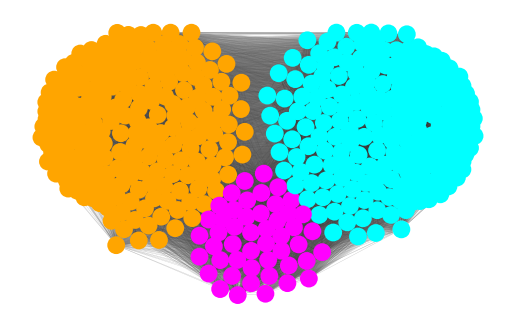

In [9]:
import matplotlib.pyplot as plt
from netgraph import Graph
fig, ax = plt.subplots()
Graph(
    players_graph,
    node_color=node_color, 
    node_edge_width=0,     
    edge_width=0.1,          
    edge_alpha=0.5,        
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=node_community),
    #edge_layout='bundled',
    ax=ax,
)

In [10]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
games = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    cols_to_drop = ['TIME']
    cols_to_drop.extend(game.columns[game.columns.str.match(r'P._TO_LAPTOP')])
    game.drop(columns=cols_to_drop, inplace=True)
    conv = game.rolling(window=5).mean().dropna().reset_index(drop=True)
    games.append(conv)
games

[      P1_TO_P1  P1_TO_P2  P1_TO_P3  P1_TO_P4  P1_TO_P5  P1_TO_P6  P1_TO_P7  \
 0          0.0    0.0606    0.1240    0.0026    0.0488    0.0296    0.0810   
 1          0.0    0.0676    0.1394    0.0038    0.0540    0.0324    0.1164   
 2          0.0    0.0812    0.1630    0.0056    0.0674    0.0418    0.1796   
 3          0.0    0.0944    0.1846    0.0066    0.0786    0.0496    0.2636   
 4          0.0    0.1020    0.1856    0.0066    0.0874    0.0564    0.3438   
 ...        ...       ...       ...       ...       ...       ...       ...   
 7314       0.0    0.0944    0.3762    0.0000    0.1628    0.0098    0.3472   
 7315       0.0    0.0840    0.3324    0.0000    0.1374    0.0076    0.4314   
 7316       0.0    0.0774    0.3226    0.0000    0.1296    0.0074    0.4586   
 7317       0.0    0.0674    0.2792    0.0000    0.1068    0.0048    0.5400   
 7318       0.0    0.0764    0.2708    0.0002    0.1050    0.0092    0.5332   
 
       P2_TO_P1  P2_TO_P2  P2_TO_P3  ...  P6_TO_P5

In [11]:
from math import sqrt
def create_graph_instance(row: pd.Series) -> nx.Graph:
    """Create a graph representing a moment in the game."""
    players = round(sqrt(len(conv.iloc[0])))
    matrix = conv.iloc[0].values.reshape(-1, players)
    return nx.Graph(matrix)

from typing import Callable
# Python 3.12+ for the generic T, otherwise use:
# def calculate_metric(row: pd.Series, *, metric):
def calculate_metric[T](row: pd.Series, *, metric: Callable[[nx.Graph], T]) -> T:
    G = create_graph_instance(row)
    return metric(G)

def return_true(row):
    return True

example_conv = games[0]
example_conv.apply(calculate_metric, axis=1, metric=return_true)

0       True
1       True
2       True
3       True
4       True
        ... 
7314    True
7315    True
7316    True
7317    True
7318    True
Length: 7319, dtype: bool